## Deep Learning Exam: Image Deblurring

by Lorenzo Orsini

The deep learning model that I have developed for this task is a Convolutional Neural Network followed by an Autoencoder. In fact, given an original image x, each corrupted image x' can be modeled as:

x' = G*x + g,

where G is the Gussian kernel convolved with x, which causes the blurring, and g is the gaussian noise. To recover the original image, this model first removes the noise g with a CNN and then performs a deblurring step with an Autoencoder, to remove the effect of the kernel G. The CNN aims to remove the Gaussian Noise from the original image, with a residual learning approach: the network is trained to remove only the noise, while the deblurring task is left to the Autoencoder, which takes as input the denoised image of the CNN. The following figure shows the whole pipeline:

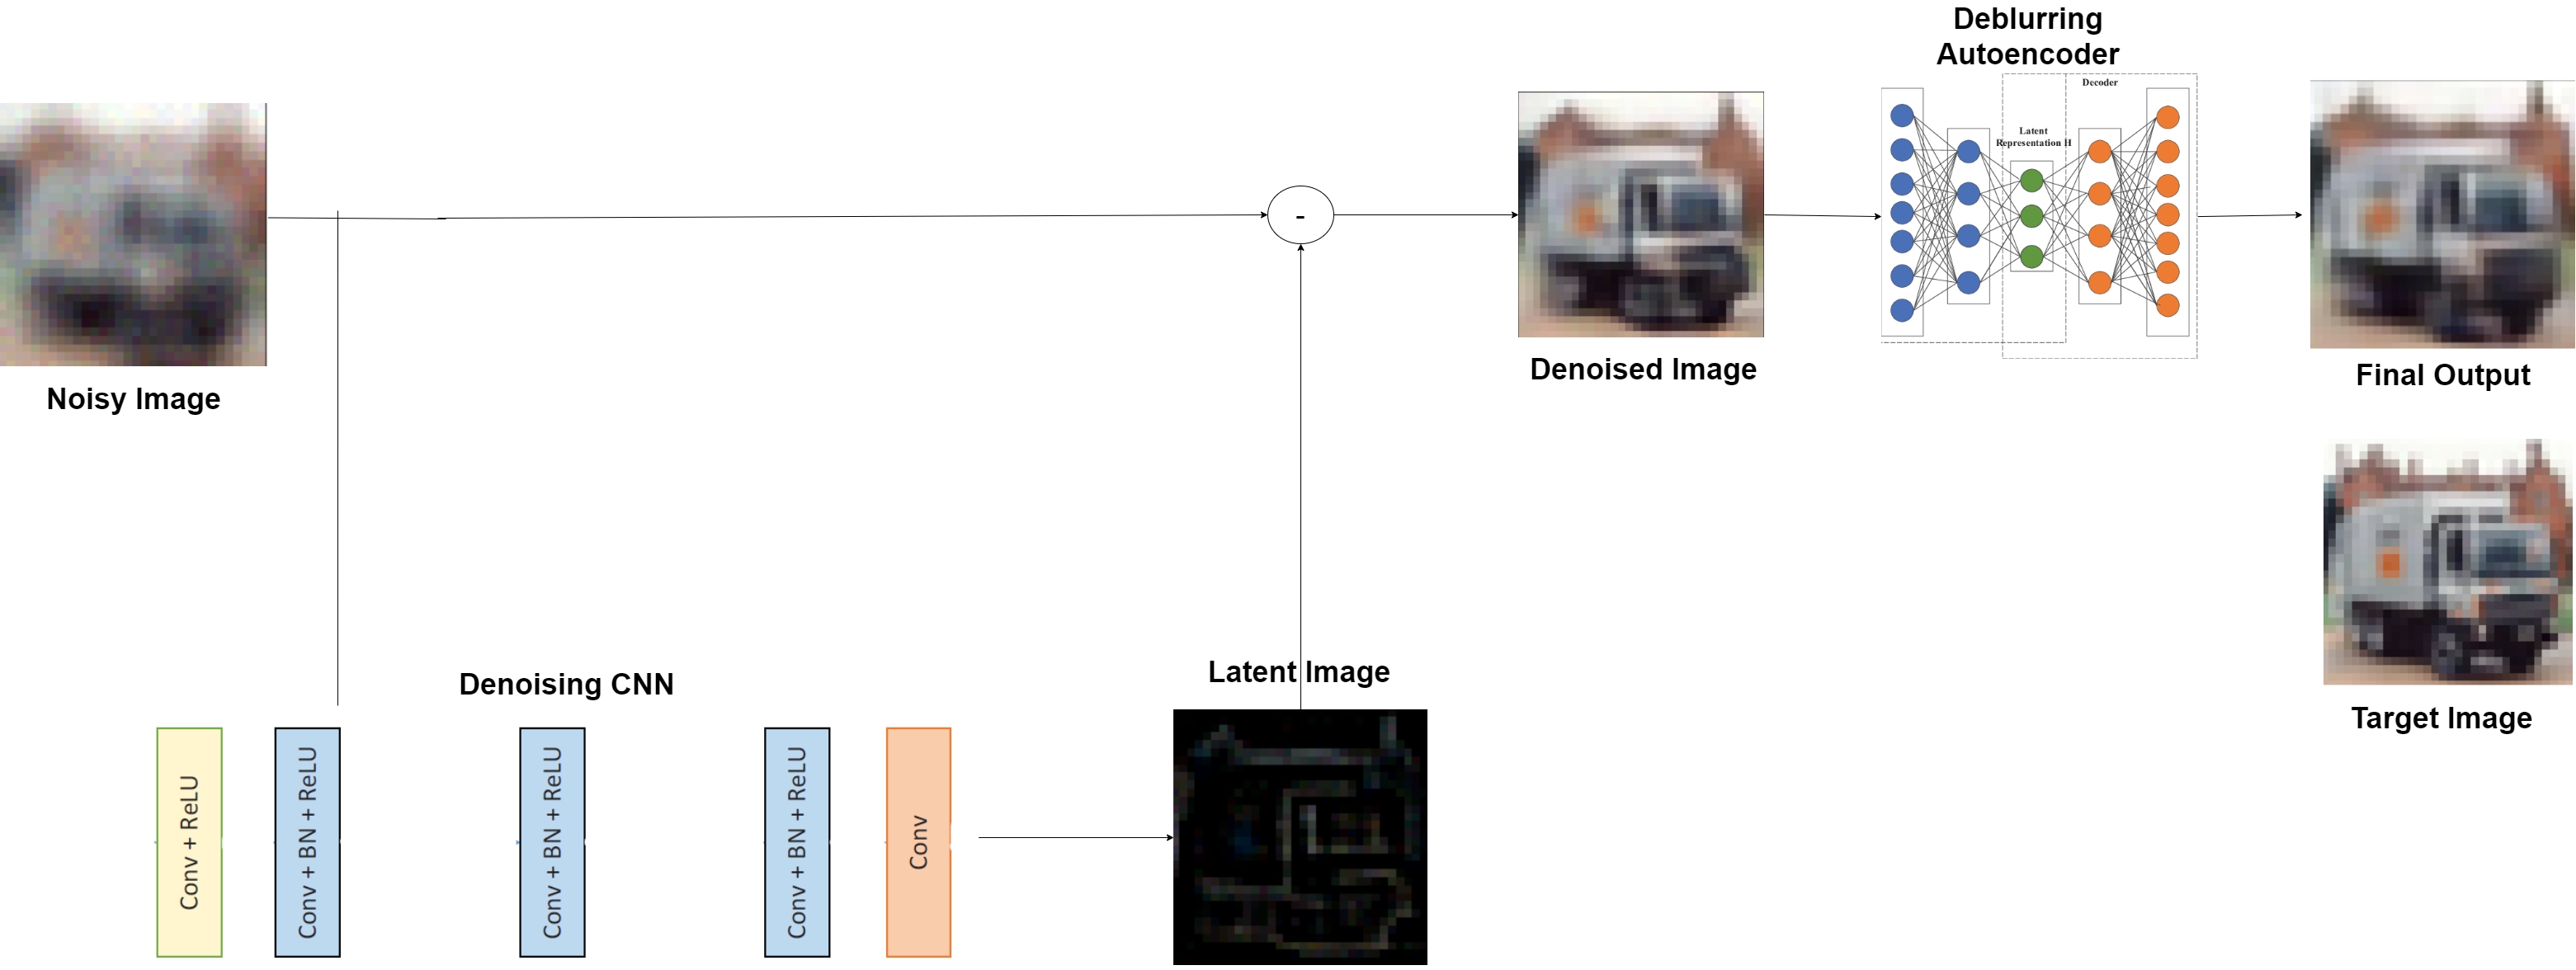

The final result on the test set is a MSE = 0.0022, with 452,590 trainable parameters

# 1. Libraries 
Let's import the libraries used for this project:

In [ ]:
# Utilities
import numpy as np
import matplotlib.pyplot as plt

# Deep Learning
import tensorflow as tf
from tensorflow import keras

# Check tensorflow version (must be >2!)
print(tf.__version__)

2.8.2


# 2. Dataset

Here there is the creation of the dataset:

In [ ]:
import random
from cv2 import GaussianBlur

def getDataset():
  (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
  normalize = lambda x: x/x.max()
  x_train = normalize(x_train)
  x_test = normalize(x_test)
  createBlurred = lambda arr: np.array([GaussianBlur(x, (5,5), ((random.random()*3)+1)) + (0.02*np.random.normal(0,1, (32, 32, 3))) for x in arr])
  return (createBlurred(x_train), x_train), (createBlurred(x_test), x_test)

Then I saved the noise image of the test set in the variable *noise_train* and the target images in the variable *target_train*. For the test set, the noise images are stored in *noise_test* and the target images in *target_test*

In [ ]:
x_train, x_test = getDataset()

noise_train = x_train[0] # train noise images
target_train = x_train[1] # target images
noise_test = x_test[0] # test noise images
target_test = x_test[1] # test images
  

170508288/170498071 [==============================] - 2s 0us/step


# 3. The Architecture of the model

Regarding the network, I took inspiration from the architecture of the DnCNN of the following paper [1], which uses residual learning and batch normalization to speed up the training process as well as improve the denoising performance. In particular, I choose the residual learning approach due to its effectiveness and efficiency, being implemented severally by the researchers [2].
In the original DnCNN, there are three types of layers:
- Conv+ReLU: for the first layer, 64 filters of size 3x3 are used to generate 64 feature maps, and rectified linear units (ReLU) is utilized for
nonlinearity;
- Conv+BN+ReLU: Here in each layer 64 filters of size 3x3 are used, and batch normalization is added between convolution and ReLU (15 layers) 
- Conv: for the last layer, 3 filters of size 1x1 are used to reconstruct the output image;

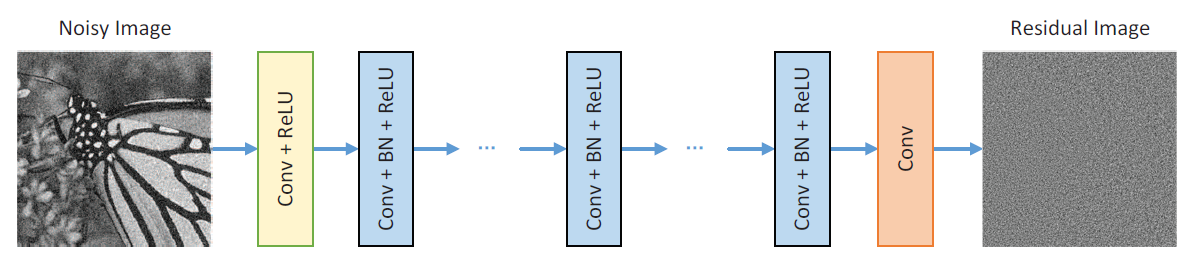

For this task, I modified the architecture iof the DnCNN. First of all, I used 16 convolutional layers:
- the first layer (Conv + BN + LeakyReLU) added a Batch Normalization wrt the one of the DnCNN, and 64 filters of size 3x3 are used to generate 64 feature maps;
- then there are 10 layers of Conv + BN + LeakyReLU, each one with 64 filters of size 3x3. In addition, after the fourth and ninth layer I have added 32 filters of size 1x1, each one followed by Batch Normalization and LeakyReLU;
- after this convolutional layers, I added two convolutional layers, one with 32 filters of size 3x3 followed by 3 filters of size 1x1. Each convolution is followed by Batch Normalization and LeakyReLU;
- finally, the last convolutional layer has 3 filters with size 3x3. 

Regarding the activation function, I have changed the original ReLu function of the DnCNN with the LeakyReLu, as suggested in [4]. In fact the ReLu function is prone to neuronal necrosis, which means that some neurons may never be activated. For this reason I used the LeakyReLu, which has all the advantages of the ReLU function but also solves some of the neuronal necrosis problems: by changing form ReLu to LuckyReLu I saw experimentally that the performance of the network increases. 
In addition, I only used 14 convolutional layer between the first and the last one: to reduce the number of parameters and speed up the training process I also used only 10 layers with 64 filters 3x3, two 1x1 convolutions (to learn pattern across the channels) and other two 3x3 convolutions with 32 and 16 filters (which perform always a 3x3 convolution). In this way, the performance of the network is still good and the number of parameters is reduced. Finally the last convolutional layer applies a 1x1 convolution with 3 filters, producing a residual image of the same dimension of the input. This step is different from the DnCNN, which uses a 3x3 convolution, and it is inspired by [4], as I saw experimentally that the performance improves. Then it is performed the residual step between the residual image and the noisy one, obtaining the final output of the network.

Regarding the Autoencoder, I took inspiration from the autoencoder [3], which performs deblurring on FashionMNIST (each image is a grayscale of size 28 x 28) dataset corrupted by Gaussian blur. The encoder is composed by 4 convolutional layers, with decreasing number of filters (64,32,16,8) of the same size 2x2. Reversely, the decoder performs 4 transposed deconvolutions with 16,32,64 filters (of the same size 2x2) and the last one with a filter 1x1, to reconstruct the final image.
Its architecture can be resumed as follows:





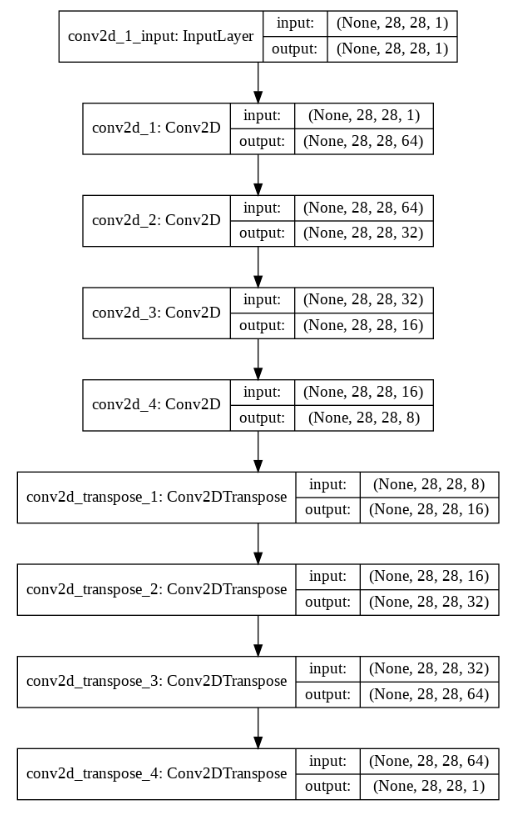








In the autoencoder of my model I left unchanged the size of the filters (seeing that 3x3 and 5x5 get worse MSE), while I added one more convolutional layers both in the encoder and the decoder, with 128 filters 2x2 to further improve the performance of the network.

In [ ]:
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Input, Conv2D, Activation, BatchNormalization, Subtract, LeakyReLU, Conv2DTranspose

# Input Layer:

input = Input(shape=(32, 32, 3), name = 'Input_Layer') 

# First Convolutional Layer

x = Conv2D(64, kernel_size=(3,3), padding='same', name = 'Conv2D_3x3')(input)

x = BatchNormalization(axis=-1, name = 'BatchNormalization')(x)

x = LeakyReLU(name = 'LeakyReLu')(x)

# Now the other Convolutional Layers

for i in range(10):

  x = Conv2D(64, kernel_size=(3,3), padding='same', name = 'Conv2D_3x3_' + str(i))(x)

  x = BatchNormalization(axis=-1, name = 'BatchNormalization_' + str(i))(x)

  x = LeakyReLU(name = 'LeakyReLu_' + str(i))(x)

  # The 1x1 Conv: 

  if i == 3 or i == 8:

    x = Conv2D(32, kernel_size=(1,1), padding='same', name = 'Conv2D_1x1_' + str(i+1))(x)
  
    x = BatchNormalization(axis=-1, name = 'BatchNormalization_1x1_' + str(i+1))(x)

    x = LeakyReLU(name = 'LeakyReLu_1x1_' + str(i+1))(x)
    
# Last two 3x3 convolutional Layers:

x = Conv2D(32, kernel_size=(3,3), padding='same', name = 'Conv2D_3x3_' + str(i+1))(x)
  
x = BatchNormalization(axis=-1, name = 'BatchNormalization_' + str(i+1))(x)

x = LeakyReLU(name = 'LeakyReLu_' + str(i+1))(x)

x = Conv2D(16, kernel_size=(3,3), padding='same', name = 'Conv2D_1x1_' + str(i+2))(x)
  
x = BatchNormalization(axis=-1, name = 'BatchNormalization_' + str(i+2))(x)

x = LeakyReLU(name = 'LeakyReLu_' + str(i+2))(x)

# Last convolutional layer, a 1x1 convolution

x = Conv2D(3, kernel_size=(1,1), padding='same', name = 'Conv2D_3x3_' + str(i+3))(x)

# Residual unit:

x = Subtract(name = 'Residual')([input, x])

# Autoencoder for deblurring

# Encoder

x = Conv2D(128, (2, 2), strides = 1, padding = 'same', name = 'Encoder_conv_128')(x)

x = Conv2D(64, (2, 2), strides = 1, padding = 'same', name = 'Encoder_conv_64')(x)

x = Conv2D(32, (2,2), strides = 1, padding = 'same', name = 'Encoder_conv_32')(x)

x = Conv2D(16, (2, 2), strides = 1, padding = 'same', name = 'Encoder_conv_16')(x)

x = Conv2D(8, (2, 2), strides = 1, padding = 'same', name = 'Encoder_conv_8')(x)

# Decoder

x = Conv2DTranspose(16, (2, 2), strides = 1, padding = 'same', name = 'Decoder_conv_16')(x)

x = Conv2DTranspose(32, (2, 2), strides = 1, padding = 'same', name = 'Decoder_conv_32')(x)

x = Conv2DTranspose(64, (2, 2), strides = 1, padding = 'same', name = 'Decoder_conv_64')(x)

x = Conv2DTranspose(128, (2, 2), strides = 1, padding = 'same', name = 'Decoder_conv_128')(x)

x = Conv2DTranspose(3, (1, 1), strides = 1, padding = 'same', name = 'final_conv_1x1')(x)

model = Model(input, x)

model._name = "DL_exam_Orsini"

model.summary()


Model: "DL_exam_Orsini"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Layer (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 Conv2D_3x3 (Conv2D)            (None, 32, 32, 64)   1792        ['Input_Layer[0][0]']            
                                                                                                  
 BatchNormalization (BatchNorma  (None, 32, 32, 64)  256         ['Conv2D_3x3[0][0]']             
 lization)                                                                                        
                                                                                                  
 LeakyReLu (LeakyReLU)          (None, 32, 32, 64)   0           ['BatchNormalization

# 4.Training
For this task the loss function used is the Mean Squared Error (MSE) between the original images and the corrupted ones. The optimizer chosen is Adam, and the learning rate was set to 0.01 after tuning the values between 10^-1 and 10^-6. 

In [ ]:
opt = keras.optimizers.Adam(learning_rate = 0.01)

model.compile(loss = 'mse', optimizer = 'adam')

Then, I used the callback ModelCheckpoint to save the best weigths of the model through the entire training, based on the loss function (MSE) on the validation set, which contains the 10% images of the training set. The weigths are saved on the file 'DL_exam_Lorenzo_Orsini_weights'.

In [ ]:
from keras.callbacks import ModelCheckpoint

#cb = EarlyStopping(monitor='val_loss', patience= 3, verbose=1, mode='auto')

chkpt = 'DL_exam_Lorenzo_Orsini_weights'

cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto')

Regarding the batch size, the papers of DnCNN and Autoencoders used a batch size = 2000. However this size leads to bad performance of the whole model, so I set a much less value equal to 50, after a tuning between 32, 40, 50, and 70. The number of epochs is 40.

In [ ]:
history = model.fit(noise_train, target_train, batch_size = 50, epochs= 40, validation_split=0.1, callbacks=[cp_cb], verbose = 1)

Epoch 1/40
900/900 [==============================] - ETA: 0s - loss: 0.0085
Epoch 1: val_loss improved from inf to 0.00403, saving model to DL_exam_Lorenzo_Orsini_weights
900/900 [==============================] - 62s 67ms/step - loss: 0.0085 - val_loss: 0.0040
Epoch 2/40
900/900 [==============================] - ETA: 0s - loss: 0.0038
Epoch 2: val_loss improved from 0.00403 to 0.00350, saving model to DL_exam_Lorenzo_Orsini_weights
900/900 [==============================] - 61s 68ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 3/40
900/900 [==============================] - ETA: 0s - loss: 0.0034
Epoch 3: val_loss improved from 0.00350 to 0.00316, saving model to DL_exam_Lorenzo_Orsini_weights
900/900 [==============================] - 61s 68ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 4/40
900/900 [==============================] - ETA: 0s - loss: 0.0030
Epoch 4: val_loss improved from 0.00316 to 0.00303, saving model to DL_exam_Lorenzo_Orsini_weights
900/900 [==================

The best MSE on the validation set is reached at the 40th epoch, with the validation loss = 0.00220.

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


Let' visually see the performance of the model on training and validation set:

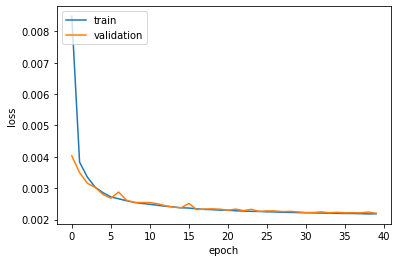

In [ ]:
def plot_history(model_history,keys):
    m,val_m = keys
    plt.plot(model_history.history[m])
    plt.plot(model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_history(history,['loss','val_loss'])

As we can see from the graph and from the results of each epoch, the validation loss is very close to the the train loss, with the best MSE = 0.00220 on the validation set reached at the 40th epoch.

# 5.Test

Let's now see the performance of the model on the test set, by using the weights of model saved previously at the 40th epoch (the one with the best validation loss):

In [ ]:
model.load_weights(chkpt)

test = model.evaluate(noise_test, target_test)

313/313 [==============================] - 6s 16ms/step - loss: 0.0022


The loss function is 0.0022, which is the same result of the training: so the model performs equally good on the training and test set, which shows no overfitting. Let's now see how is the output of the model:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Output of the model')

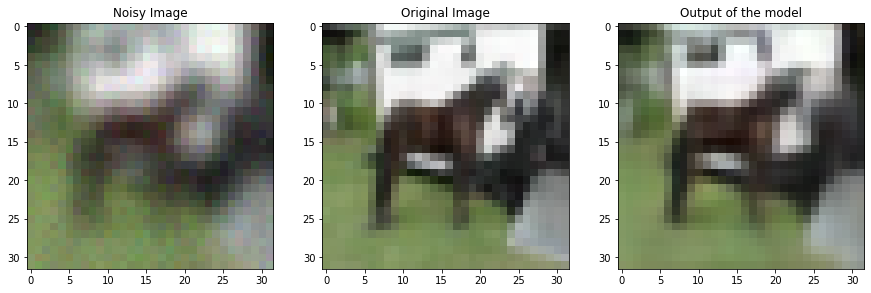

In [ ]:
from matplotlib import pyplot as plt

pred = model.predict(noise_test)

fig = plt.figure(figsize=(15, 15))
rows = 1
columns = 3

# Noisy image
fig.add_subplot(rows, columns, 1)
plt.imshow(noise_test[20])
plt.title("Noisy Image")
  
# Original Image
fig.add_subplot(rows, columns, 2)
plt.imshow(target_test[20])
plt.title("Original Image")
  
# Output of the model
fig.add_subplot(rows, columns, 3)
plt.imshow(pred[20])
plt.title("Output of the model")



# 6.Bibliography and sitography

[1] Kai Zhang, Wangmeng Zuo, Yunjin Chen, Deyu Meng, and Lei Zhang: Beyond a Gaussian Denoiser: Residual Learning of Deep CNN for Image Denoising, https://arxiv.org/pdf/1608.03981.pdf

[2] Ademola E. Ilesanmi & Taiwo O. Ilesanmi: Methods for image denoising using convolutional neural network: a review, https://link.springer.com/article/10.1007/s40747-021-00428-4

[3] De-Noising a Gaussian Blurred Image, https://github.com/done-n-dusted/deblur-fashionmnist/blob/master/Denoising_v1.ipynb

[4] ShanGaiZhongyunBao: New image denoising algorithm via improved deep convolutional neural network with perceptive loss, https://reader.elsevier.com/reader/sd/pii/S0957417419305111?token=D37EBAAC4FF2EEFCA833DB5A0A06D9BECEB60F79450896AB800607ADDC884358B164AF7C6EEF54464C43137B82B0F466&originRegion=eu-west-1&originCreation=20220604120310
